In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../src')

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
import torch
import torch.nn.functional as F

import pandas as pd
import numpy as np

import os
from tqdm.auto import tqdm

from rocket import ROCKET, Logreg
from ucr_utils import load_ucr_seq, train_val_split
from uncertainty_estimation import *
import matplotlib.pyplot as plt

from sklearn.metrics import roc_auc_score

### Settings

In [5]:
PATH_TO_UCR = '../data/Univariate_ts/'
PATH_TO_BAKEOFF_SEQUENCES = '../data/results_ucr_bakeoff.csv'
PATH_TO_ADDITIONAL_SEQUENCES = '../data/results_ucr_additional.csv'

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

torch.manual_seed(0)

### Load data

In [6]:
bakeoff_sequences = pd.read_csv(PATH_TO_BAKEOFF_SEQUENCES)
additional_sequences = pd.read_csv(PATH_TO_ADDITIONAL_SEQUENCES)
all_sequences = pd.concat([bakeoff_sequences, additional_sequences])
all_sequences = all_sequences.set_index('dataset')

### Calculate uncertainty with dropout

In [7]:
dropout_uncertainties = {}
p_dropout = 0.1

for seq in tqdm(all_sequences.index):
    
    if seq == 'Crop':
        dropout_samples = 200
    else:
        dropout_samples = 500
        
    x, y, x_test, y_test = load_ucr_seq(PATH_TO_UCR, seq, device)
    x_train, y_train, x_val, y_val = train_val_split(x, y, val_size=0.3, seed=9)

    rocket = ROCKET(input_len=x_train.size(2), n_kernels=10000, kernels_sizes_set=torch.tensor([7, 9, 11]), device=device)

    x_train_rocket = rocket.generate_random_features(x_train)
    const_columns_mask = (x_train_rocket.std(0) == 0)
    x_train_rocket = x_train_rocket[:,  ~const_columns_mask]
    x_train_rocket_mean, x_train_rocket_std = x_train_rocket.mean(0), x_train_rocket.std(0)
    x_train_rocket = (x_train_rocket - x_train_rocket_mean) / x_train_rocket_std

    x_test_rocket = rocket.generate_random_features(x_test) 
    x_test_rocket = x_test_rocket[:,  ~const_columns_mask]
    x_test_rocket = (x_test_rocket - x_train_rocket_mean) / x_train_rocket_std

    x_val_rocket = rocket.generate_random_features(x_val) 
    x_val_rocket = x_val_rocket[:,  ~const_columns_mask]
    x_val_rocket = (x_val_rocket - x_train_rocket_mean) / x_train_rocket_std

    logreg = Logreg(
        n_features=x_train_rocket.size(1),
        n_classes=len(torch.unique(y_train)),
        p_dropout=p_dropout, 
        lr=1e-2,
        weight_decay=1e-1,
        epochs_to_wait=5,
        tol=1e-4,
        max_steps=500,
        ignore_first_n_steps=100,
        device=device
    )

    logreg.train(x_train_rocket, y_train, x_val_rocket, y_val)

    # Dropout samples
    logits_samples = []
    for _ in range(dropout_samples):
        _, _, logits = logreg.validate(x_test_rocket, y_test, mode='train')
        logits_samples.append(logits)
    logits_samples = torch.stack(logits_samples, dim=2)
    preds = F.softmax(logits_samples, dim=1).mean(dim=2).argmax(dim=1)
    acc = accuracy(y_test, preds)

    # Uncertainty estimation
    rejection_rates = torch.linspace(0, 1-1/len(y_test), len(y_test)-1).to(device)
    metrics = estimate_uncertainty_on_ensemble(logits_samples, y_test)
    irc = ideal_rejection_curve(preds, y_test, rejection_rates)

    aucs = {'accuracy': acc}
    for metric_name, metric_values in metrics.items():
        if (acc == 1.0):
            aucs[metric_name+'_roc_auc'] = 1.
            aucs[metric_name] = 1.
        else:
            aucs[metric_name+'_roc_auc'] = roc_auc_score((y_test == preds).cpu().numpy(), -metric_values.cpu().numpy())
            rc = rejection_curve(metric_values, preds, y_test, rejection_rates, accuracy).to(device)
            aucs[metric_name] = AUC(rejection_rates, irc, rc) 

    dropout_uncertainties[seq] = aucs

100%|█████████████████████████████████████████████████████████████████████████████████| 128/128 [27:51<00:00, 13.06s/it]


In [8]:
pd.DataFrame.from_dict(dropout_uncertainties, orient='index').to_csv('../results/uncertainty_results_dropout.csv')

### Visualization of rejection curves

In [9]:
dropout_uncertainties = {}
dropout_samples = 1000
p_dropout = 0.1

seq = all_sequences.index[0]
    
x, y, x_test, y_test = load_ucr_seq(PATH_TO_UCR, seq, device)
x_train, y_train, x_val, y_val = train_val_split(x, y, val_size=0.3, seed=9)
    
rocket = ROCKET(input_len=x_train.size(2), n_kernels=10000, kernels_sizes_set=torch.tensor([7, 9, 11]),device=device)
    
x_train_rocket = rocket.generate_random_features(x_train)
const_columns_mask = (x_train_rocket.std(0) == 0)
x_train_rocket = x_train_rocket[:,  ~const_columns_mask]
x_train_rocket_mean, x_train_rocket_std = x_train_rocket.mean(0), x_train_rocket.std(0)
x_train_rocket = (x_train_rocket - x_train_rocket_mean) / x_train_rocket_std

x_test_rocket = rocket.generate_random_features(x_test) 
x_test_rocket = x_test_rocket[:,  ~const_columns_mask]
x_test_rocket = (x_test_rocket - x_train_rocket_mean) / x_train_rocket_std

x_val_rocket = rocket.generate_random_features(x_val) 
x_val_rocket = x_val_rocket[:,  ~const_columns_mask]
x_val_rocket = (x_val_rocket - x_train_rocket_mean) / x_train_rocket_std

logreg = Logreg(
    n_features=x_train_rocket.size(1),
    n_classes=len(torch.unique(y_train)),
    p_dropout=p_dropout, 
    lr=1e-2,
    weight_decay=1e-1,
    epochs_to_wait=5,
    tol=1e-4,
    max_steps=500,
    ignore_first_n_steps=100,
    device=device
)

logreg.train(x_train_rocket, y_train, x_val_rocket, y_val)

# Dropout samples
logits_samples = []
for _ in tqdm(range(dropout_samples)):
    _, _, logits = logreg.validate(x_test_rocket, y_test, mode='train')
    logits_samples.append(logits)
logits_samples = torch.stack(logits_samples, dim=2)
preds = F.softmax(logits_samples, dim=1).mean(dim=2).argmax(dim=1)
acc = accuracy(y_test, preds)

# Uncertainty estimation
rejection_rates = torch.linspace(0, 1-1/len(y_test), len(y_test)-1).to(device)
# rejection_rates = torch.linspace(0, 1 - 1e-9, 10000).to(device)
metrics = estimate_uncertainty_on_ensemble(logits_samples, y_test)
irc = ideal_rejection_curve(preds, y_test, rejection_rates)

rcs = {}
for metric_name, metric_values in metrics.items():
    rc = rejection_curve(metric_values, preds, y_test, rejection_rates, accuracy)
    rcs[metric_name] = rc

rejection_rates = rejection_rates.cpu().numpy()

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 327.03it/s]


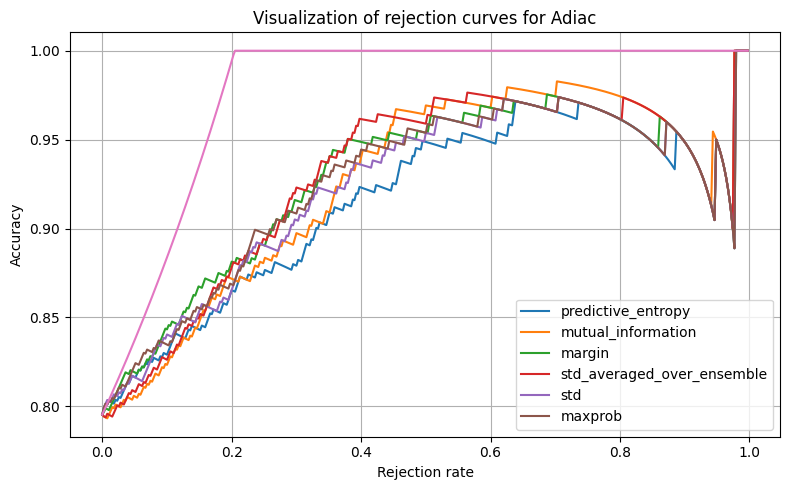

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

for metric, values in rcs.items():
    ax.plot(rejection_rates, values.numpy(), label=metric)

ax.plot(rejection_rates, irc.cpu().numpy())
ax.set_title(f'Visualization of rejection curves for {seq}')
ax.set_xlabel('Rejection rate')
ax.set_ylabel('Accuracy')
ax.grid(visible=True)
plt.legend()
plt.tight_layout()

plt.savefig('../results/example_rc.pdf')